### DATA558 HW4
Emily Yamauchi

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error

Objective function:

$$
\begin{align}
F(\beta)=\frac{1}{2n}\sum_{i=1}^n(y_i-x_i^\top \beta)^2 + \lambda||\beta||_1
\end{align}
$$

Find 

$$
 F(\beta^*)=\min_{\beta \in \mathbb{R}^d}F(\beta)
$$

**Algorithm 1** Cooridinate Descent Algorithm, general form  
**initialization** $\beta=0$  
**repeat** for $t=0,1,2,...$  
- Pick a coordinate index $j$ in $\{1,...d\}$  
- Find $\beta_j^{new}$ by minimizing $F(\beta)$ with respect to $\beta_j$ only.  
- Perform update $\beta_j^{(t+1)}=\beta_j^{new}$.
- Perform update $\beta_\ell^{(t+1)}=\beta_\ell^{(t)}$ for all $\ell\neq j$.  

**until** the stopping criterion is satisfied.

1. Assume that $d=1$ and $n=1$. The sampe is then of size 1 and boils down to just $(x,y)$; the learning parameter $\beta$ is then a scalar. The function $F$ writes simply as  
$$
\begin{align}
F(\beta)&=\frac{1}{2}(y-x\beta)^2+\lambda | \beta |
\end{align}
$$
The solution to the minimization problem $\min_\beta F(\beta)$ is given by soft thresholding:  

$$
\beta = \begin{cases} \frac{xy-\lambda}{x^2} & xy>\lambda \\ 0 & |xy|\leq \lambda \\ \frac{xy+\lambda}{x^2} & xy<-\lambda \end{cases}
$$

Implement the function $F(\beta)$ in the $n=1, d=1$ case. Implement a soft thresholding function that returns $\beta$ given $x, y, \lambda$. Plot $F(\beta)$, setting $x=1, y=1, \lambda=0.5$, and show visually that the minimum is obtained by your soft thresholding function.

In [2]:
def soft_thresholding(x, y, lamb):
    """
    Implement soft thresholding function that returns beta given x, y, and lambda
    When n = 1, d = 1
    """
    beta = 0
    
    if (x*y) > lamb:
        beta = (x*y - lamb)/(x**2)
    
    if (x*y) < -lamb:
        beta = (x*y + lamb)/(x**2)
    
    return beta

In [3]:
soft_thresholding(1, 1, 0.5)

0.5

In [4]:
def obj_func_1(beta, x, y, lamb):
    """
    Objective function when n = 1, d = 1
    """
    
    f1 = (y - x*beta)**2
    f2 = lamb * np.abs(beta)
    
    return f1/2 + f2

In [5]:
obj_func_1(0.5, 1, 1, 0.5)

0.375

In [6]:
x = 1
y = 1
lamb = 0.5

obj_x = np.linspace(-2, 2, 100)
obj_y = [obj_func_1(b, x, y, lamb) for b in obj_x]

In [7]:
min_x = soft_thresholding(x, y, lamb)
min_y = obj_func_1(min_x, x, y, lamb)

Text(0.5, 0.375, 'min')

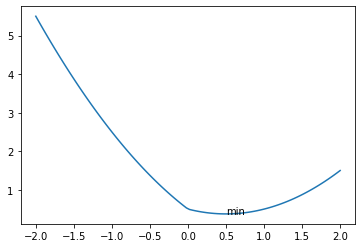

In [8]:
fig, ax = plt.subplots()
ax.plot(obj_x, obj_y)
ax.annotate('min', xy = (min_x, min_y))

2. Assume now that $d>1$ and $n>1$. The full minimization problem now writes as  
$$
\begin{align}
F(\beta)&=\frac{1}{2n}\sum_{i=1}^n(y_i-x_i^\top \beta)^2+\lambda || \beta ||_1
\end{align}
$$

Write a function *computeobj* that computes and returns $F(\beta)$ for any $\beta$, given $X, y,$ and $\lambda$. Plot this function by first generating some data, and then passing your implementation of *computeobj* as an argument to the plotting function provided.

In [9]:
np.random.seed(123)

X = np.random.normal(size=(10,2))
beta = np.array([2.0, -5.0])
y = np.dot(X, beta) + np.random.normal(10)
lam = 3.0

In [10]:
def plot_objective(X, y, computeobj, lambda_, min_beta=None, iterates=None):
    nb = 100
    brange = np.linspace(-10, 10, nb)
    b1, b2 = np.meshgrid(brange, brange)
    
    z = np.array([computeobj(beta, X, y, lambda_) for beta in zip(b1.ravel(), b2.ravel())])
    
    levels = np.logspace(-5, 4 ,100)
    
    plt.figure(figsize=(6,6))
    
    plt.hlines(y=0, xmin=-10, xmax=10, color='k')
    plt.vlines(x=0, ymin=-10, ymax=10, color='k')
    
    if min_beta is not None:
        plt.scatter(min_beta[0], min_beta[1], marker='x', s=100, color='k')
    
    if iterates is not None:
        #Arrows
        for j in range(1, len(iterates)):
            plt.annotate(
            "",
            xy=iterates[j],
            xytext=iterates[j-1],
            arrowprops={"arrowstyle:": "->", "color":color, "lw": 1},
            va="center",
            ha="center",
        )
    
    plt.contour(brange, brange, z.reshape((nb, nb)), levels=levels)

In [11]:
def computeobj(beta, X, y, lamb):
    """
    Return the objective function where n>1 and d>1
    """
    
    n = len(X)
    f1 = 1/(2*n)*sum((y-X.dot(beta))**2)
    f2 = np.linalg.norm(beta) * lamb
    
    return f1 + f2

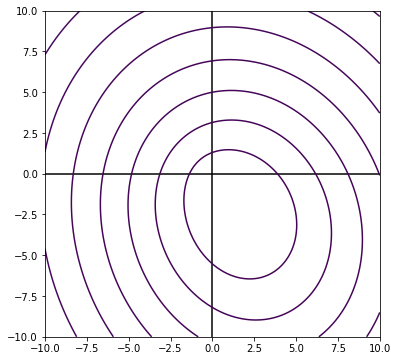

In [12]:
plot_objective(X, y, computeobj, lam)

3. Coordinate descent proceeds by sequential partial minimization with respect to each coordinate $\beta_j$, that by solving partial minimization problems of form 
$$
\min_{\beta_j}=\frac{1}{2n}\sum_{i=1}^n\{y_i-(\beta_ix_{i,1}+...+\beta_ix_{i,j}+...+\beta_ix_{i,d}\}^2 \\
+\lambda\{|\beta_1|+...+|\beta_j|+...+|\beta_d|\}
$$

Write a function *partial_min* that takes $X, y, \beta, \lambda$ and an index $j$, and returns the vector $\tilde{\beta}$ that results from minimizing $F(\beta)$ along coordinate $j$, starting at the point $\beta$. Using the same $X, y, \lambda$ as above, evaluate this function from the starting point `beta_init` and on the coordinate $j=1$:  
`beta_init = np.array([5.0, 5.0])  
j = 1`  
Generate the same contour plot as above, this time adding the initial point and the point that results from your partial minimization.  

$$
\min_{\beta_j}=\underbrace{ \frac{1}{2n}\sum_{i=1}^n\{y_i-(\beta_ix_{i,1}+...+\beta_ix_{i,j}+...+\beta_ix_{i,d}\}^2 }_1 \\
+\underbrace{ \lambda\{|\beta_1|+...+|\beta_j|+...+|\beta_d|\} }_2 \\
$$
Part 1 is minimized as \
$$
\begin{align}
\min_{\text{Part1}}&=-\frac{1}{n}X_j^\top(y-X_{-j}\beta_{-j}-X_j\beta_j)
\end{align}
$$
Part 2 is minimized as
$$
\min_\text{Part2} = \begin{cases} -\lambda & \beta < 0 \\ [-\lambda, \lambda] & \beta = 0 \\ \lambda & \beta > 0 \end{cases}
$$

Therefore, putting both together 

$$
\min_{\beta_j} = \begin{cases} \frac{\gamma_j - \lambda}{\eta_j} & \gamma_j > \lambda \\ 0 & -\lambda \leq \gamma_j \leq \lambda \\ \frac{\gamma_j + \lambda}{\eta_j} & \gamma_j < -\lambda \end{cases},
$$

and 
$$
\gamma_j = \frac{1}{n} X_j^T(y-X_{-j}^T\beta_{-j}) \\
\eta_j = \frac{1}{n} X_j^TX_j.
$$ 

In [13]:
def partial_min(beta, X, y, lamb, j):
    """
    Implements partial minimization to return vector beta' that results from minimizing F(Beta) along the j-coordinate
    X: nxd
    beta: 1xd
    y: nx1
    lamb: scalar
    j: index
    Returns: a number
    """
    n = X.shape[0]
    
    X_j = X[:,j]
    beta_j = beta[j]
    
    X_jMin = np.delete(X, j, axis = 1)
    beta_jMin = np.delete(beta, j, axis = 0)
    
    gamma = (X_j.T.dot(y - X_jMin.dot(beta_jMin))) * (1/n)
    eta = X_j.T.dot(X_j) * (1/n)
    
    min_b = 0
    
    if gamma > lamb:
        
        min_b = (gamma - lamb)/eta
    
    if gamma < -lamb:
        
        min_b = (gamma + lamb)/eta
    
    return min_b

In [14]:
j = 1
beta_init = np.array([5, 5])

j_coord = partial_min(beta_init, X, y, lam, j)

In [15]:
np.array([5, j_coord])

array([ 5.        , -1.99460278])

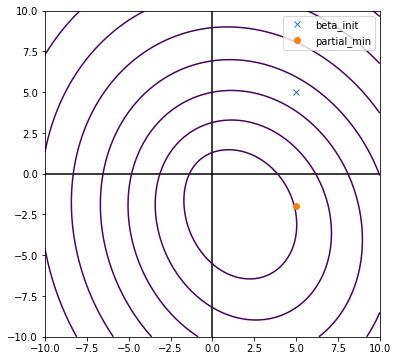

In [16]:
plot_objective(X, y, computeobj, lam)
plt.plot(beta_init[0], beta_init[1], 'x', label = 'beta_init')
plt.plot(beta_init[0], j_coord, 'o', label = 'partial_min')
plt.legend()

4. Download the file `HW4_data.csv` from the course website. The data is a subset of the `superconductivity` dataset from the UCI Machine Learning Repository. It consists of $n=100$ observations of $d=20$ features and one response. The goal is to predict the response, `critical_temp` from the features. Load the datas as a Pandas data frame, seperating it into features $X$ and response $y$. Standardize $X$ and $y$.

In [17]:
sc_df = pd.read_csv('data/HW4_data.csv')

In [18]:
sc_df.head()

,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,wtd_std_atomic_mass,...,wtd_mean_fie,gmean_fie,wtd_gmean_fie,entropy_fie,wtd_entropy_fie,range_fie,wtd_range_fie,std_fie,wtd_std_fie,critical_temp
0,84.231574,57.842763,66.164102,36.112184,1.430024,1.138253,122.90607,33.640786,47.428396,53.589094,...,1009.946857,752.280835,937.287219,1.545214,0.812484,810.6,749.048857,294.283693,356.200361,5.0
1,88.944468,57.894262,66.361592,36.124868,1.181795,0.932518,122.90607,37.319570,51.968828,53.669752,...,1011.040571,718.152900,939.406232,1.305967,0.764604,810.6,746.035714,323.811808,354.499974,10.2
2,75.100250,51.579798,61.298642,35.158873,1.456708,1.390133,121.32760,19.623906,39.288902,44.284202,...,998.089172,705.732671,930.382127,1.542128,0.937941,810.6,690.345940,291.828474,346.349554,75.0
3,74.231650,51.480943,60.515221,35.113886,1.453747,1.340115,121.32760,20.650805,39.445875,44.246346,...,1003.200310,771.891022,937.305449,1.552506,0.929772,810.6,694.888235,282.395259,341.811885,53.0
4,119.942725,91.077409,90.003794,73.231604,1.590565,1.551095,191.20060,29.007229,70.961415,55.280514,...,721.865714,701.448928,687.113728,1.733547,1.540374,786.5,192.422857,268.928309,255.944162,90.0


In [19]:
sc_df.describe()

,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,wtd_std_atomic_mass,...,wtd_mean_fie,gmean_fie,wtd_gmean_fie,entropy_fie,wtd_entropy_fie,range_fie,wtd_range_fie,std_fie,wtd_std_fie,critical_temp
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,91.267645,62.470845,67.279305,41.675547,1.395333,1.334107,152.256706,25.776280,58.278272,55.536758,...,956.027671,723.822880,894.398244,1.557373,1.037880,795.254000,614.867748,290.555839,327.890152,46.928450
std,13.178910,13.281850,11.217558,13.215335,0.198448,0.264124,33.090412,8.612678,11.402871,7.958495,...,104.030450,30.938495,88.685229,0.212991,0.312775,21.098118,193.434543,31.212202,47.947602,36.916864
min,61.357238,47.618152,26.270151,30.713727,0.841338,0.932518,121.327600,11.027092,39.288902,43.145819,...,672.349583,638.226141,650.065839,1.021250,0.735100,723.700000,112.575000,234.380907,198.201132,4.000000
25%,83.729846,55.882976,64.751718,35.386005,1.181795,1.042813,122.906070,17.586018,48.238804,52.815410,...,955.593125,711.262897,886.470287,1.310185,0.787670,779.450000,607.678594,272.228524,330.875111,16.875000
50%,89.170086,57.878393,66.361592,36.120091,1.410948,1.358984,128.242600,25.567512,51.968828,53.651884,...,1007.517857,718.152900,937.348037,1.542583,0.939611,810.600000,694.877527,292.557305,345.385521,29.450000
75%,99.020971,62.507538,72.743816,39.962886,1.565293,1.546790,192.981000,34.255312,71.240702,61.258296,...,1010.661464,734.596714,939.100102,1.731008,1.091495,810.600000,738.769286,323.811808,355.241277,75.875000
max,142.376700,98.641607,98.761740,85.768282,1.818121,1.796118,192.981000,37.619066,78.477440,79.823052,...,1035.975000,831.170151,971.036295,1.904838,1.748310,810.600000,752.715000,347.221961,367.904468,121.000000


In [20]:
scX = sc_df.drop(columns = 'critical_temp', axis = 1)
scy = sc_df['critical_temp']

In [21]:
scXs = np.array((scX - scX.mean())/scX.std())
scys = np.array((scy - scy.mean())/scy.std())

In [22]:
print('scXs.shape: ', scXs.shape)
print('scys.shape: ', scys.shape)

scXs.shape:  (100, 20)
scys.shape:  (100,)


5. Use the sklearn function `LassoCV` to find a suitable choice for the regularization parameter $\lambda$, with  
`alphas = np.logspace(-2, 2, 31)`  
and using the keyword parameter `cv=5` to specify 5-fold cross-validation. Report the best-performing choice of $\lambda$. Repeat the question for $n-$fold cross-validation that is *leave-one-out* cross validation. 

In [23]:
alphas = np.logspace(-2, 2, 31)
beta_sc = np.zeros(scXs.shape[1])

In [24]:
best_lamb = LassoCV(alphas=alphas, cv = 5).fit(scXs, scys).alpha_
print('best_lamb: ', best_lamb )

best_lamb:  0.025118864315095794


In [25]:
def get_fold_indices(n, K, j):
    """
    Helper function: return the indices for train and validation sets based on the K fold
    j-th fold where j in [1,K] is validation, while rest is training 
    """
    
    val_idx = np.arange(int(n/K * (j-1)), int(n/K * j))
    train_idx = np.array([x for x in list(np.arange(0,n-1)) if x not in list(val_idx)])
    
    return train_idx, val_idx

In [26]:
def leave_one_out_cv(lambs, X, y, K):
    """
    N-fold cross validation using leave-one-out method
    """
    n = X.shape[0]
    best_perf = np.inf

    for i in range(len(lambs)):
        
        alpha = lambs[i]
        mses = np.zeros(K)
        
        for j in range(K):

            train_idx, val_idx = get_fold_indices(n, K, j)
            X_train, y_train = X[train_idx], y[train_idx]
            X_val, y_val = X[val_idx], y[val_idx]
            m = Lasso(alpha=alpha).fit(X_train, y_train)
            mses[j] = mean_squared_error(m.predict(X_val), y_val)
            
        performance = mses.mean()
        if performance < best_perf:
            best_perf = performance
            best_lamb = alpha
    
    return best_lamb

In [27]:
best_lamb_lvo = leave_one_out_cv(alphas, scXs, scys, 5)
print('best_lamb leave one out: ', best_lamb_lvo)

best_lamb leave one out:  0.025118864315095794


6. We will implement two versions of coordinate descent, corresponding to two methods for selecting the index $j$. First, write a function *cyclicoorddescent* that implements the *cyclic coordinate descent* algorithm. The cyclic version of this algorithm selects $j$ by starting at $j=0$ and incrementing it sequentially (modulo $d$) in each iteration. Thus we first minimize with respect to the coordinate $\beta_0$, then $\beta_1$, and so on. Set a maximum iteration number as the stopping criterion. 

In [28]:
def coorddescent(beta, X, y, lamb, j):
    
    min_j = partial_min(beta, X, y, lamb, j)
    new_beta = beta.copy()
    new_beta[j] = min_j
    
    return new_beta

In [29]:
def cyclicoorddescent(beta_init, X, y, lamb, max_iter=20):
    
    d = X.shape[1] #nxd matrix, find for each feature of X
    t = 0
    beta = beta_init.copy()
    betas = [beta]

    while t < max_iter:
        
        j = t % d
        new_beta = coorddescent(beta, X, y, lamb, j)
        betas.append(new_beta)
        beta = new_beta
        t += 1

    return betas

7. Next write a function (or modify the previous function such that it can perform either selection method) such that the index $j$ is chosen uniformly at random. You may wish to use your solution to part (c).

In [30]:
def randcoorddescent(beta_init, X, y, lamb, max_iter=20):
    
    d = X.shape[1]
    t = 0
    beta = beta_init.copy()
    betas = [beta]
    
    while t < max_iter:
        
        j = np.random.choice(d)
        new_beta = coorddescent(beta, X, y, lamb, j)
        betas.append(new_beta)
        beta = new_beta
        t += 1
    
    return betas

In [31]:
#randcoorddescent(beta_sc, scXs, scys, best_lamb)

8. Run both implementations, *cyclicoorddescent* and *randcoorddescent*, on data $X, y$ using the value of $\lambda$ selected previously (either by 5-fold or leave-one-out cross validation). Set the maximum number of iterations to 20000. For both variants, cyclic and randomized, of coordinate descent, plot the Lasso objective as a function of the iteration number.

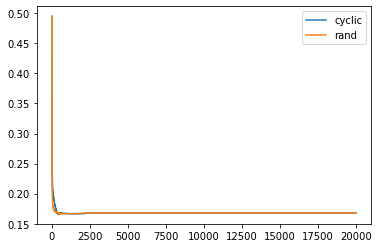

In [32]:
max_iter = 20000

cyclicB = cyclicoorddescent(beta_sc, scXs, scys, best_lamb, max_iter)
randB = randcoorddescent(beta_sc, scXs, scys, best_lamb, max_iter)

cyclic_obj = [computeobj(b, scXs, scys, best_lamb) for b in cyclicB]
rand_obj = [computeobj(b, scXs, scys, best_lamb) for b in randB]

plt.plot(cyclic_obj, label = 'cyclic')
plt.plot(rand_obj, label = 'rand')
plt.legend()

9. Compare the final iterate of each method to the result of sklearn's `Lasso`.

In [33]:
scm = Lasso(alpha = best_lamb).fit(scXs, scys)

In [34]:
scm.coef_

array([-0.        , -0.        , -0.45142002, -0.        , -0.        ,
        0.        ,  0.07841981, -0.25991172,  0.38611701,  0.        ,
        0.        , -0.        ,  0.        , -0.58010652,  0.        ,
        0.        ,  0.06387462, -0.        , -0.        , -0.        ])

In [35]:
cyclicB[-1]

array([ 0.        ,  0.        , -0.45144977,  0.        ,  0.        ,
        0.        ,  0.07762793, -0.26003005,  0.38682371,  0.        ,
        0.        ,  0.        ,  0.        , -0.58021548,  0.        ,
        0.        ,  0.06388352,  0.        ,  0.        ,  0.        ])

In [36]:
randB[-1]

array([ 0.        ,  0.        , -0.45144977,  0.        ,  0.        ,
        0.        ,  0.07762793, -0.26003005,  0.38682371,  0.        ,
        0.        ,  0.        ,  0.        , -0.58021548,  0.        ,
        0.        ,  0.06388352,  0.        ,  0.        ,  0.        ])

In [37]:
scm.coef_ - cyclicB[-1]

array([-0.00000000e+00, -0.00000000e+00,  2.97442408e-05, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  7.91873947e-04,  1.18327314e-04,
       -7.06694253e-04,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  1.08956092e-04,  0.00000000e+00,  0.00000000e+00,
       -8.90074977e-06, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00])

In [38]:
scm.coef_ - randB[-1]

array([-0.00000000e+00, -0.00000000e+00,  2.97442408e-05, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  7.91873947e-04,  1.18327314e-04,
       -7.06694253e-04,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  1.08956092e-04,  0.00000000e+00,  0.00000000e+00,
       -8.90074977e-06, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00])

The three methods produce very close results.

10. Comment on the sparsity of the result. Which features are selected by your coordinate descent method?

In [39]:
np.nonzero(cyclicB[-1])

(array([ 2,  6,  7,  8, 13, 16]),)

In [40]:
np.nonzero(randB[-1])

(array([ 2,  6,  7,  8, 13, 16]),)

In [41]:
np.nonzero(scm.coef_)

(array([ 2,  6,  7,  8, 13, 16]),)

In [42]:
sc_df.columns[np.nonzero(randB[-1])]

Index(['gmean_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass',
       'std_atomic_mass', 'wtd_gmean_fie', 'range_fie'],
      dtype='object')

`gmean_atomic_mass`, `range_atomic_mass`, `wtd_range_atomic_mass`, `std_atomic_mass`, `wtd_gmean_fie`, `range_fie` were the features chosen (from all three methods)

11. Plot the regularization paths for the randomized variant of coordinate descent. Comment on the regularization paths.

In [43]:
def get_lasso_coefs(X, y, lambs, sk=False):
    
    coefs = []
    beta_init = np.zeros(X.shape[1])
    
    for lamb in lambs:
        
        if not sk:
            
            betas = randcoorddescent(beta_init, X, y, lamb, 20000)
            coefs.append(betas[-1])
            
        else:
            coefs.append(Lasso(alpha=lamb).fit(X, y).coef_)

    
    return np.array(coefs)

In [44]:
def plot_reg_path(coefs, lambs, df):
    
    d = coefs.shape[1]
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot()
    col_name = df.columns
    
    for j in range(d):
        
        ax.plot(lambs, coefs[:,j], label=col_name[j])
        

    plt.gca().invert_xaxis() # plot w/ lambda decreasing from left to right
    ax.set_xlabel(r'$\lambda$')
    ax.set_ylabel('coefficients')
    ax.legend(frameon=False, loc='upper left', fontsize=10)

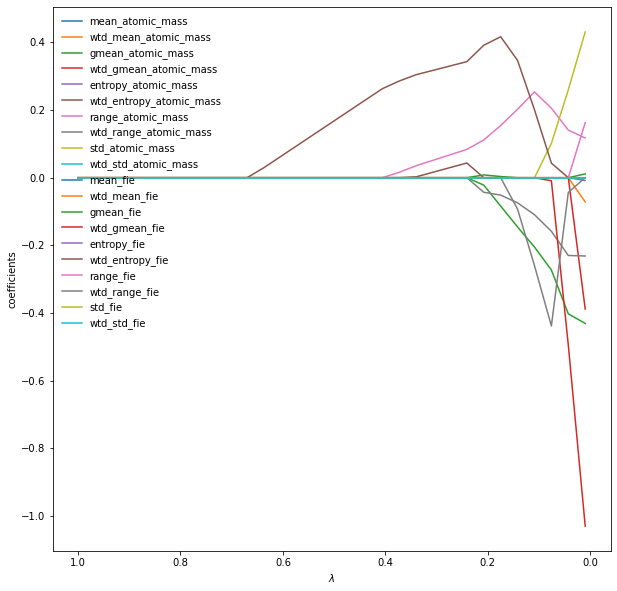

In [45]:
lamb_range = np.linspace(0.01, 1, 31)
coefs = get_lasso_coefs(scXs, scys, lamb_range)
plot_reg_path(coefs, lamb_range, sc_df)

With enough iterations, the regularization path shows that with increasing penalty, the coefficients are dropped to 0. 
The default `max_iter = 20` did not show the above chart, but showed the coefficients reverting to and from 0. At 20,000 iterations, the above chart shows similar output to coefficients calculated from sklearn's Lasso method.

Text(0.5, 1.0, 'sklearn Lasso method coefficients')

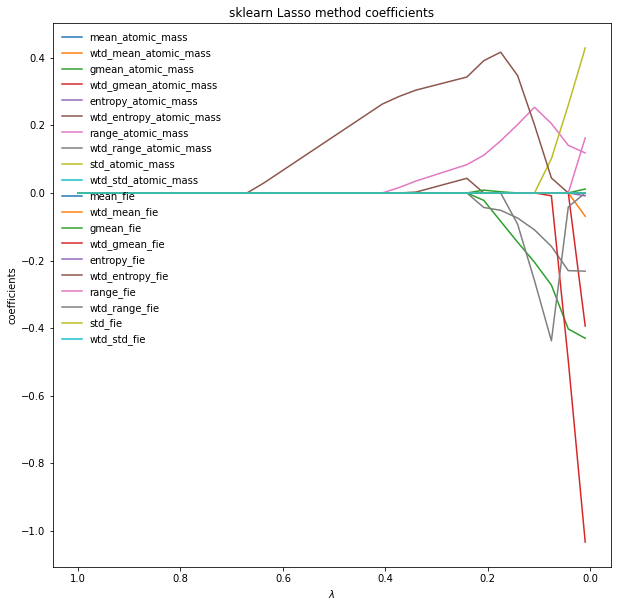

In [46]:
coefs_sk = get_lasso_coefs(scXs, scys, lamb_range, True)
plot_reg_path(coefs_sk, lamb_range, sc_df)
plt.title('sklearn Lasso method coefficients')